## Portfolio: Walmart Weekly Sales Forecast ##
This is a portfolio based on the historical sales data for 45 Walmart stores located in different regions of the United States. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact. The dataset can be found here https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data.

**Goal:**
To predict the weekly sales forecasts across 45 different regional stores evaluated by mean-absolute-errors (MAEs).

**Results:** 
By comparing the different regressor model performances, XGBoost was the best with MAE: 1249 on a test set.

**Risks:** With visual inspection from residual and quantile plots, there were some errors for making accurate predictions. Especially, from low to middle range of weekly sales were deviated a lot from forecasted weekly sales.

**Mitigation:** 
Review these identified errors and outliers with Walmart store manager(s) and operation/marketing directors before making any promotional markdown events to generate more revenue across the different stores.

**Future Work:**
1. Model improvements: feasibility of testing other ensemble models, stacking and neural network.
2. Data collection/refinement: integrate with other financial and job market-related data sources 
    * Household income by Walmart store regions 
    * KPIs on accessibility to Walmart stores (i.e., # of store visits, # of parking tickets issued, etc.)

**Recommendation for clients:** 
1. Recommendation 1
2. Recommendation 2

## Part 1 - DEFINE ##

**Problem Statement:** 
You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains several departments, and you are tasked with predicting the department-wide sales for each store. In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

**Stakeholders:** 
Marketing/Operational Director(s), Store Manager(s), Data Science Team

**Goal:**
To predict the weekly sales forecast model for time-series problem(s).

In [1]:
# Import all libraries #
import sys
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import statsmodels.api as sm
import scipy.stats as sp
import sklearn.metrics as skm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures 
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

## Part 2 - DISCOVERY ##

In [2]:
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def create_list_vars(df, dt_type):
    '''create a list of variables '''
    list_vars = list(df.select_dtypes(include=dt_type))
    return list_vars


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_as_category(df):
    '''convert datatype from object to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')            

        
def drop_column(df, var_name):
    ''' drop a column on dataframe '''
    df = df.drop(var_name, axis=1)
    return df


def bind_data(df_train, df_test):
    ''' bind train and test dataframes as one '''
    df_concat = pd.concat([df_train, df_test], axis=0)
    return df_concat


def clean_data(raw_df):
    '''remove rows that contain invalid data or duplicate IDs'''
    clean_df = raw_df.drop_duplicates(subset='row_id')
#    clean_df = clean_df[clean_df['health__homicides_per_100k'] > 0]
    return clean_df    


def join_data(df1, df2, join_type, key=None,
              left_index=None, right_index=None):
    '''merge the dataframes by a key'''
    df_join = pd.merge(df1, df2, how=join_type, on=key,
                       left_index=False, right_index=False)
    return df_join


def avg_groupby_data(cleaned_df, num_var, cat_var, avg_var_name):
    '''groupby categorical var to calculate an average numerical feature'''
    avg_groupby_cat_val = cleaned_df.groupby(cat_var)[num_var].mean().sort_values(ascending=False)
    avg_groupby_cat_df = pd.DataFrame({cat_var:list(cleaned_df[cat_var].unique()),
                                      avg_var_name:avg_groupby_cat_val})
    avg_groupby_cat_df.reset_index(drop=True, inplace=True)
    return avg_groupby_cat_df


def encode_categorical_feature(df, var_name, map_name):
    '''encode categorical features into mapping values'''
    df[var_name] = df[var_name].map(map_name)
    return df[var_name]


def EDA_missing_data(df):
    ''' compute missing value % on a df'''
    df_missing = pd.DataFrame(df.isnull().sum())
    df_missing.columns = ['count']
    df_missing = df_missing.sort_values(by='count', ascending=False)
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def EDA_summary_stat_num(df):
    ''' compute numerical summary statistics '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', '25%', '50%', '75%', 'std']]
    df_stat_num = df_stat_num.sort_values(by='count', ascending=True)
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def EDA_summary_stat_cat(df):
    ''' compute numerical summary statistics '''
    df_stat_cat = pd.DataFrame(df.describe(include='category').T)
    return df_stat_cat


def EDA_inspect_data_quality(df, col_name):
    '''compute indexes for rows with negative values on a selected feature'''
    idx_list = list(df.loc[df[col_name]<0].index)
    return idx_list


def EDA_feature_importance_plot(model, X, y):
    '''plots the feature importance plot on trained model'''
    model = model
    model.fit(X, y)
    feat_labels = X.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90, fontsize=7)
    plt.xlim(-1, X.shape[1])


def apply_binning(df, new_var, old_var, bins, labels):
    '''apply binning on a selected variable'''
    df[new_var] = pd.cut(df[old_var], bins=bins,
                          labels=labels, include_lowest=True)
    return df[new_var]

            
def feature_replacement(df):
    '''impute missing values based on specific data type and a column'''
    for column in df.columns:
        if df[column].dtype.name == 'object':
            mode = df[column].mode().iloc[0]
            df[column] = df[column].fillna(mode)
        elif df[column].dtype.name == 'float64':
            mean = df[column].mean()
            df[column] = df[column].fillna(mean)
        elif df[column].dtype.name == 'datetime64[ns]':
            pseudo_date = pd.Timestamp.max
            df[column] = df[column].fillna(pseudo_date)
        else:
            md_cols = df.columns[df.columns.str.contains(pat = 'MarkDown')]
            df[md_cols] = df[md_cols].fillna(0)


def feature_scaling(X):
    '''Feature scaled data based on standardization'''
    sc_X = StandardScaler()
    X_std = sc_X.fit_transform(X)
    return X_std


def feature_selection(df, model, feat_name, Est_Coef, file_name):
    '''Creates L1 feature selected dataframe'''
    df_L1_select = pd.DataFrame({feat_name:df.columns, Est_Coef:model.coef_})[[feat_name, Est_Coef]]
    df_L1_select = df_L1_select.sort_values(by=Est_Coef, ascending=False)
    df_L1_select.to_excel(file_name)
    return df_L1_select


def format_dummy_vars(df, var_name):
    '''format dummy variables in recognized names'''
    df[var_name] = var_name + '_' + df[var_name].map(str)


def get_dummies(df, var_name):
    '''Create a list of dummy vars'''
    dummies = pd.get_dummies(df[var_name], drop_first=True)
    return dummies    


def split_dataframe(df):
    '''Split data into train and test sets'''
    df_final_train, df_final_test = df.loc[df['File_Type']=='Train'], df.loc[df['File_Type']=='Test']
    return df_final_train, df_final_test


def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''Performs RandomizedSearchCV to tune model parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=5)
    random_search.fit(feature_df, label_df)
    return random_search


def print_best_params(random_search, param_1=None, param_2=None, param_3=None):
    '''Print the best model parameter'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])


def model_train(model, X_train, y_train, n_proc, mean_mae, cv_std):
    '''Train a model and output mean MAE and CV Std. MAE'''
    #scoring = 'neg_mean_absolute_error', 'neg_mean_squared_error'
    # dont forget np.sqrt() for RMSE metric!
    neg_mae = cross_val_score(model, X_train, y_train, n_jobs=n_proc, cv=5,
                              scoring='neg_mean_absolute_error')
    mae = -1*neg_mae
    mean_mae[model] = np.mean(mae)
    cv_std[model] = np.std(mae)


def model_summary(model, mean_mae, cv_std):
    '''Print out the model performance summary'''
    print('\nModel:\n', model)
    print('Average MAE:\n', mean_mae[model])
    print('Std. Dev during CV:\n', cv_std[model])

    
def model_results(model, mean_mae, predictions, feature_importances):
    '''Saves the model name, mean_mae, predicted sales, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv',index=False)
        predictions.to_csv('pred_results_best.csv',index=False,index_label=None)


def gen_predictions_file(df, var_1, var_2, var_3):
    '''Generate test predictions file: concatenate with 3 keys to make the id column'''
    df['id'] = df[var_1].map(str)+'_'+df[var_2].map(str)+'_'+df[var_3].map(str)
    return df[['id', 'Weekly_Sales_Pred']]


def plot_reg_compare(y_train_pred, y_train_act):
    '''Plot a scatter plot to compare predicted vs actual label'''
    plt.scatter(y_train_pred, y_train_act, c='blue', 
                edgecolor='w', marker='o', label='train set')
    plt.xlabel('Predicted weekly sales')
    plt.ylabel('Actual weekly sales')
    plt.legend(loc='upper left')


def plot_reg_residual(y_train_pred, y_train_act):
    '''Plot a scatter plot to visualize residual from predicted vs. actual label'''
    plt.scatter(y_train_pred, (y_train_pred - y_train_act), c='blue',
                edgecolor='w', marker='o', label='train set')
    plt.hlines(y=0, xmin=0, xmax=max(y_train_act), colors='k', lw=3)
    plt.xlim([0, max(y_train_act)])
    plt.xlabel('Predicted weekly sales')
    plt.ylabel('Residual weekly sales')
    plt.legend(loc='upper left')    

In [3]:
# --- 2. Load the data --- #
# define input CSVs:
if __name__ == '__main__':
    test_data = 'sales_test.csv'
    train_data = 'sales_train.csv'
    store_data = 'sales_stores.csv'
    feature_data = 'sales_features.csv'

# Load data
df_test = load_file(test_data)
df_train = load_file(train_data)
df_store = load_file(store_data)
df_feature = load_file(feature_data)

# Create a column file_type:
# distinguish the train vs. test files
df_train['File_Type'] = 'Train'
df_test['File_Type'] = 'Test'

# re-order columns on df_train:
list_order = ['Store','Dept','Date','IsHoliday','File_Type','Weekly_Sales']
df_train = df_train[list_order]

# concatenate df_train and df_test:
df_walmart_sales = bind_data(df_train, df_test)
# delete dataframes:
del(df_train, df_test)

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
# --- 3. ETL - metadata format --- #
# left joins on feature and store data:
list_key_1 = 'Store'
df_dimension = join_data(df_feature, df_store, 'left', list_key_1)

# left joins on df_dimension and df_walmart_sales:
list_key_2 = ['Store', 'Date', 'IsHoliday']
df_staging = join_data(df_walmart_sales, df_dimension, 'left', list_key_2)
# delete keys and dataframes:
del(df_walmart_sales, df_dimension, df_feature, df_store)
del(list_key_1, list_key_2)

In [5]:
# --- 4. ETL - merging/subsetting data --- #
# define variables:
var_label = 'Weekly_Sales'
var_id_1 = 'Store'
var_id_2 = 'Dept'
var_id_3 = 'Date'
list_id_vars = [var_id_1, var_id_2, var_id_3]

vars_cat = create_list_vars(df_staging, 'O')
vars_num_disc = create_list_vars(df_staging, 'int64') 
vars_num_cont = create_list_vars(df_staging, 'float64')

# concatenate the two lists:
vars_num = vars_num_disc + vars_num_cont

list_unwanted = {'Store','Dept'}

vars_num = [item for item in vars_num if item not in list_unwanted]

del(vars_num_disc, vars_num_cont)

# check data types on dataframes:
df_staging.info()

# create a dataframe with label:
df_label = df_staging[['Store','Dept','Date','Weekly_Sales']]

# drop a specified column:
df_staging = drop_column(df_staging, var_label)

# merge on a walmart sales and label:
df_staging_raw = join_data(df_staging, df_label, 'inner', list_id_vars)
del(df_staging)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536634 entries, 0 to 536633
Data columns (total 17 columns):
Date            536634 non-null object
Dept            536634 non-null int64
File_Type       536634 non-null object
IsHoliday       536634 non-null bool
Store           536634 non-null int64
Weekly_Sales    421570 non-null float64
Temperature     536634 non-null float64
Fuel_Price      536634 non-null float64
MarkDown1       265596 non-null float64
MarkDown2       197685 non-null float64
MarkDown3       242326 non-null float64
MarkDown4       237143 non-null float64
MarkDown5       266496 non-null float64
CPI             498472 non-null float64
Unemployment    498472 non-null float64
Type            536634 non-null object
Size            536634 non-null int64
dtypes: bool(1), float64(10), int64(3), object(3)
memory usage: 70.1+ MB


In [6]:
# --- 6. Feature Encoding --- #
# convert temperature "Fahrenheit" to "Celsious":
df_staging_raw['Temperature'] = (df_staging_raw['Temperature'] - 32) * 5/9

# format date as follow:
date_format = '%Y-%m-%d'
df_staging_raw['Date'] = pd.to_datetime(df_staging_raw['Date'])

In [7]:
# --- 7. Feature Imputation --- #
# Compute missing value %: before replacement
df_missing_pre = EDA_missing_data(df_staging_raw)
df_missing_pre

,count,pct
MarkDown2,338949,63.162043
MarkDown4,299491,55.809173
MarkDown3,294308,54.843338
MarkDown1,271038,50.507049
MarkDown5,270138,50.339337
Weekly_Sales,115064,21.441802
CPI,38162,7.111365
Unemployment,38162,7.111365
Fuel_Price,0,0.000000
Temperature,0,0.000000


####  Feature Imputation ####
Let's compute feature imputation to replace missing values by following:
* Mode: categorical features
* Mean: numerical features
* Max: pseudo time stamp on missing date(s)
* Custom: customized values to fill na (i.e., fillna with zero(s))

In [8]:
# feature imputation:
feature_replacement(df_staging_raw)

# Compute missing value %: after replacement
df_missing_post = EDA_missing_data(df_staging_raw)
df_missing_post

del(df_missing_pre, df_missing_post)

#### Feature Engineering 1 ####
Feature engineering is a process where feature are generated by data transformation of existing feature(s). 

**Nominal feature encoding:** markdown promotional sales availability/presence md1_presence to md5_presence is a nominal feature where it can be described by binary digits (0 or 1)

In [9]:
# --- 8. Feature Engineering --- #
# assign a feature: binary flag
#df_staging_raw = df_staging_raw.assign(md1_presence = df_staging_raw.MarkDown1.notnull())
#df_staging_raw = df_staging_raw.assign(md2_presence = df_staging_raw.MarkDown2.notnull())
#df_staging_raw = df_staging_raw.assign(md3_presence = df_staging_raw.MarkDown3.notnull())
#df_staging_raw = df_staging_raw.assign(md4_presence = df_staging_raw.MarkDown4.notnull())
#df_staging_raw = df_staging_raw.assign(md5_presence = df_staging_raw.MarkDown5.notnull())

In [10]:
# --- 9. Exploratory Data Analysis --- #
# perform numerical stat:
df_stat_num = EDA_summary_stat_num(df_staging_raw[vars_num])
df_stat_num

,count,min,mean,max,25%,50%,75%,std
Size,536634.0,34875.000000,136678.550960,219622.000000,93638.000000,140167.000000,202505.000000,61007.711799
Weekly_Sales,536634.0,-4988.940000,15981.258123,693099.360000,3240.535000,12982.345000,15981.258123,20129.612399
Temperature,536634.0,-21.827778,14.873201,38.861111,7.361111,15.588889,22.905556,10.377064
Fuel_Price,536634.0,2.472000,3.408310,4.468000,3.041000,3.523000,3.744000,0.430861
MarkDown1,536634.0,-2781.450000,3681.287709,103184.980000,0.000000,0.000000,5046.740000,7593.883000
MarkDown2,536634.0,-265.760000,1292.745138,104519.540000,0.000000,0.000000,118.730000,5714.136207
MarkDown3,536634.0,-179.260000,838.971725,149483.310000,0.000000,0.000000,29.140000,7860.456173
MarkDown4,536634.0,0.000000,1489.918846,67474.850000,0.000000,0.000000,906.450000,4865.593575
MarkDown5,536634.0,-185.170000,2147.337557,771448.100000,0.000000,0.000000,2852.190000,9789.902903
CPI,536634.0,126.064000,172.090481,228.976456,132.716097,172.090481,212.303441,38.110227


In [11]:
# convert data type as category:
convert_dt_as_category(df_staging_raw)

# perform summary statistics: categorical
df_stat_cat = EDA_summary_stat_cat(df_staging_raw[vars_cat])
df_stat_cat

,count,unique,top,freq
File_Type,536634,2,Train,421570
Type,536634,3,A,274191


#### One-Hot-Encoding: dummy variable  ####
One-Hot-Encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator gets interpreted by the ML models.

Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: Christmas_Eves_yes vs. Christmas_Eves_no).

In [12]:
# --- 10. Prepare Training Data --- #
# Create a dummy variable: date
df_staging_raw['Date_String'] = [datetime.strptime(date, '%Y-%m-%d').date() 
                            for date in df_staging_raw['Date'].astype(str).values.tolist()]
df_staging_raw['Month'] = [date.month for date in df_staging_raw['Date_String']]

# Create a list of dummy variables: Special Dates - Black Friday & Christmas Eve
df_staging_raw['Black_Friday'] = np.where((df_staging_raw['Date_String']==datetime(2010, 11, 26).date()) | 
        (df_staging_raw['Date_String']==datetime(2011, 11, 25).date()), 'yes', 'no')
df_staging_raw['Christmas_Eves'] = np.where((df_staging_raw['Date_String']==datetime(2010, 12, 23).date()) | 
        (df_staging_raw['Date_String']==datetime(2010, 12, 24).date()) | 
        (df_staging_raw['Date_String']==datetime(2011, 12, 23).date()) | 
        (df_staging_raw['Date_String']==datetime(2011, 12, 24).date()), 'yes', 'no')

# Re-format dummy variables: Month, IsHoliday, etc.
format_dummy_vars(df_staging_raw, 'Month')
format_dummy_vars(df_staging_raw, 'IsHoliday')
format_dummy_vars(df_staging_raw, 'Black_Friday')
format_dummy_vars(df_staging_raw, 'Christmas_Eves')

# Create a list of dummy variables:
#dummy_months = get_dummies(df_staging_raw, 'Month')
dummy_holidays = get_dummies(df_staging_raw, 'IsHoliday')
dummy_black_friday = get_dummies(df_staging_raw, 'Black_Friday')
dummy_christmas_eve = get_dummies(df_staging_raw, 'Christmas_Eves')

# Concatenate dataframe:
df_clean = pd.concat([df_staging_raw, dummy_christmas_eve, 
                      dummy_black_friday, dummy_holidays], axis=1)

del(df_staging_raw)
del(dummy_holidays, dummy_black_friday, dummy_christmas_eve)

#### Feature Engineering 2 ####

**Arithmetic Operation/Time Intelligence**. 
Feature engineering techniques are applied to generate following feature(s):

1. 'Median_Sales' = computation of median weekly sales value on training dataset only!
2. 'Lagged_1wk_Sales' = computation of 1week lagging weekly sales
3. 'Lagged_1wk_Available' = computation of a categorical feature whether or not 1week lagging weekly sales are available!

In [13]:
# --- 11. Feature Engineering --- #
# create median sales by store and department on a train set:
df_median_sales = pd.DataFrame({'Median_Sales':df_clean.loc[df_clean['File_Type']=='Train'].groupby(
                  by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()

# check dataframe:
df_median_sales.head()

,Type,Dept,Store,Month,IsHoliday,Median_Sales
0,A,1,1,Month_1,IsHoliday_False,17350.585
1,A,1,1,Month_1,IsHoliday_True,NaN
2,A,1,1,Month_10,IsHoliday_False,23388.030
3,A,1,1,Month_10,IsHoliday_True,NaN
4,A,1,1,Month_11,IsHoliday_False,19551.115


In [14]:
# perform left joins on df_clean and df_median_sales:
list_key_3 = ['Type','Dept','Store','Month','IsHoliday']
df_clean = join_data(df_clean, df_median_sales, 'left', list_key_3)
del(df_median_sales)

# imputed Median Sales:
feature_replacement(df_clean)

# create a feature: Date_Lagged_1wk
df_clean['Date_1wk_Lagged'] = df_clean['Date_String'] - timedelta(days=7)
df_clean.head()

,Date,Dept,File_Type,IsHoliday,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Weekly_Sales,Date_String,Month,Black_Friday,Christmas_Eves,Christmas_Eves_yes,Black_Friday_yes,IsHoliday_True,Median_Sales,Date_1wk_Lagged
0,2010-02-05,1,Train,IsHoliday_False,1,5.727778,2.572,0.0,0.0,0.0,...,24924.50,2010-02-05,Month_2,Black_Friday_no,Christmas_Eves_no,0,0,0,23510.49,2010-01-29
1,2010-02-12,1,Train,IsHoliday_True,1,3.616667,2.548,0.0,0.0,0.0,...,46039.49,2010-02-12,Month_2,Black_Friday_no,Christmas_Eves_no,0,0,1,37887.17,2010-02-05
2,2010-02-19,1,Train,IsHoliday_False,1,4.405556,2.514,0.0,0.0,0.0,...,41595.55,2010-02-19,Month_2,Black_Friday_no,Christmas_Eves_no,0,0,0,23510.49,2010-02-12
3,2010-02-26,1,Train,IsHoliday_False,1,8.127778,2.561,0.0,0.0,0.0,...,19403.54,2010-02-26,Month_2,Black_Friday_no,Christmas_Eves_no,0,0,0,23510.49,2010-02-19
4,2010-03-05,1,Train,IsHoliday_False,1,8.055556,2.625,0.0,0.0,0.0,...,21827.90,2010-03-05,Month_3,Black_Friday_no,Christmas_Eves_no,0,0,0,21280.40,2010-02-26


In [15]:
# Create a sorted dataframe: 1wk lagged weekly sales computation
df_clean = df_clean.sort_values(['Store', 'Dept', 'Date_String'], ascending=[True,True,True])
df_clean = df_clean.reset_index(drop=True)

# Create Lagged_1wk_Sales, Lagged_1wk_Available
df_clean['Lagged_1wk_Sales'] = np.nan
df_clean['Lagged_1wk_Available'] = np.nan

# specify row's: last and length
row_last = df_clean.loc[0]
row_len = df_clean.shape[0]

# for looping on each row:
for index, row in df_clean.iterrows():
    lag_date = row['Date_1wk_Lagged']
    # Check if it matches the last week sales to the compared date
    if((row_last['Date_String'] == lag_date) & (row_last['Weekly_Sales']>0)):
        df_clean.set_value(index, 'Lagged_1wk_Sales', row_last['Weekly_Sales'])
        df_clean.set_value(index, 'Lagged_1wk_Available', 1)
    else: #last week sales doesn't exist then replace with median sales
        df_clean.set_value(index, 'Lagged_1wk_Sales', row['Median_Sales'])
        df_clean.set_value(index, 'Lagged_1wk_Available', 0)
    row_last = row # compute last row for computational speed
    if(index%int(row_len/10)==0): # shows progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% computed')

# checked dataframe:
df_clean[['Dept','Store','Date_String','Lagged_1wk_Sales','Weekly_Sales','Median_Sales']].head()        

# compute Sales Variance: Median_Sales - Lagged_1wk_Sales
df_clean['Sales_Var_Median_Lagged'] = df_clean['Median_Sales'] - df_clean['Lagged_1wk_Sales']

# compute Sales Variance: Median_Sales - Weekly_Sales
df_clean['Sales_Var_Median_Weekly'] = df_clean['Median_Sales'] - df_clean['Weekly_Sales']

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


0% computed
9% computed
19% computed
29% computed
39% computed
49% computed
59% computed
69% computed
79% computed
89% computed
99% computed


In [16]:
# --- 12. Feature Scaling --- # 
# Normalized features based on standardization
#df_clean['Temperature'] = feature_scaler(df_clean, 'Temperature')

In [17]:
# --- 13. split data into train and test set ---
# split the data for train and test sets:
df_final_train, df_final_test = split_dataframe(df_clean)
del(df_clean)

# create a label:
label_df = df_final_train['Sales_Var_Median_Weekly']

# feature selection:
df_final_train.info()

# selected list of features:
list_feat = list(df_final_train.columns)

# create a list: object, category and datetime
list_obj = create_list_vars(df_final_train, 'O')
list_cat = create_list_vars(df_final_train, 'category')
list_dt_time = create_list_vars(df_final_train, 'datetime')
list_target = ['Weekly_Sales', 'Median_Sales', 'Sales_Var_Median_Weekly']

# concatenate a list of features to be removed:    
list_remove = list_obj + list_cat + list_dt_time + list_target

list_feat = [item for item in list_feat if item not in list_remove]
del(list_obj, list_cat, list_dt_time, list_target, list_remove)

# split data into train and validation sets:
X_train, X_val, y_train, y_val = train_test_split(df_final_train[list_feat], label_df, 
                                                  test_size=1/4, random_state=0)

# check the split:
y_train.count()
y_val.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 536594
Data columns (total 30 columns):
Date                       421570 non-null datetime64[ns]
Dept                       421570 non-null int64
File_Type                  421570 non-null category
IsHoliday                  421570 non-null object
Store                      421570 non-null int64
Temperature                421570 non-null float64
Fuel_Price                 421570 non-null float64
MarkDown1                  421570 non-null float64
MarkDown2                  421570 non-null float64
MarkDown3                  421570 non-null float64
MarkDown4                  421570 non-null float64
MarkDown5                  421570 non-null float64
CPI                        421570 non-null float64
Unemployment               421570 non-null float64
Type                       421570 non-null category
Size                       421570 non-null int64
Weekly_Sales               421570 non-null float64
Date_String         

105393

In [18]:
# --- 14. Baseline model --- # 
# Baseline Model LR: MAE = 1566.47, CV_STD_MAE = 9.40    
# create a baseline model:
baseline = LinearRegression()
baseline_cv = cross_val_score(baseline, X_train, y_train, 
                                  cv=5, scoring='neg_mean_absolute_error')
baseline_mae = -1 * baseline_cv
baseline_mean_mae = np.mean(baseline_mae)
print('Baseline MAE: ' + str(baseline_mean_mae))

Baseline MAE: 1566.476906279234


#### Summary: Baseline Model ####
Baseline model was computed to compare the performance across different set of hyper-parameters tuned models.
The Baseline MAE was 1565.19.

## Part 3 - DEVELOP ##

In [19]:
# --- 15. Create models --- # 
# initialize model list and dicts
models = []
mean_mae = {}
cv_std = {}
res = {}

# define common model parameters: num processors and shared model parameters
n_proc = 1
verbose_lv = 5

# create and tune the models that you brainstormed during part 2
###############################################################################        
# Hyper-parameters tuning: RandomForest
rf = RandomForestRegressor()   
n_iter = 10
param_dist_rf = {'n_estimators':sp.randint(10,50), 
                  'max_depth':sp.randint(1,10),
                  'min_samples_split':sp.randint(10,60)}

random_search_rf = model_tuning_param(rf, X_train, y_train, param_dist_rf, n_iter)    
    
# print the best model parameters: RandomForest    
param_1 = 'n_estimators' 
param_2 = 'max_depth'
param_3 = 'min_samples_split'
    
print_best_params(random_search_rf, param_1, param_2, param_3)
###############################################################################    

## Hyper-parameters tuning: GradientBoosting
#gbr = GradientBoostingRegressor()
#n_iter = 10
#param_dist_gbr = {'n_estimators':sp.randint(10,40), 
#                  'max_depth':sp.randint(1,20),
#                  'loss':['ls']}
#
#random_search_gbr = model_tuning_param(gbr, X_train, y_train, param_dist_gbr, n_iter)    
#    
## print the best model parameters: GradientBoosting    
#param_1 = 'n_estimators' 
#param_2 = 'max_depth'
#param_3 = 'loss'
#    
#print_best_params(random_search_gbr, param_1, param_2, param_3)        
###############################################################################    

# Hyper-parameters tuning: XGBoost
xgb = XGBRegressor()   
n_iter = 10
param_dist_xgb = {'n_estimators':sp.randint(10,40), 
                  'max_depth':sp.randint(1,20),
                  'learning_rate':np.random.uniform(0,1,10)}

random_search_xgb = model_tuning_param(xgb, X_train, y_train, param_dist_xgb, n_iter)    
    
# print the best model parameters: XGBRegressor    
param_1 = 'n_estimators' 
param_2 = 'max_depth'
param_3 = 'learning_rate'
    
print_best_params(random_search_xgb, param_1, param_2, param_3)

Best n_estimators: 16
Best max_depth: 9
Best min_samples_split: 17


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:52:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:52:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:52:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:52:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:52:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:53:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:54:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:54:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:54:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:54:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:54:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:54:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:55:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:56:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:57:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:57:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:58:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:59:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:00:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:00:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:00:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best n_estimators: 26
Best max_depth: 8
Best learning_rate: 0.2036331695038941


In [20]:
 # --- 16. Cross-validate models --- # 
# do 2-fold cross validation on models and measure MSE
# Model List to train: Order of Model Complexity
lr_L1 = Lasso(alpha=0.01)
lr_L2 = Ridge(alpha=0.01)
rf = RandomForestRegressor(n_estimators=12, n_jobs=n_proc, max_depth=9,
                               min_samples_split=39, verbose=verbose_lv)   
gbr = GradientBoostingRegressor(n_estimators=38, max_depth=10, loss='ls', verbose=verbose_lv)
xgb = XGBRegressor(n_estimators=29, max_depth=14, learning_rate=0.28722554556383273) 

# a list of regressors:
models.extend([lr_L1, lr_L2, rf, gbr, xgb])    

# cross-validate models, using MSE to evaluate and print the summaries
print("begin cross-validation")
for model in models:
    model_train(model, X_train, y_train, n_proc, mean_mae, cv_std)
    model_summary(model, mean_mae, cv_std)

begin cross-validation

Model:
 Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Average MAE:
 1566.4490160097819
Std. Dev during CV:
 12.994292819980178

Model:
 Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Average MAE:
 1566.4766941124387
Std. Dev during CV:
 12.99479551851815
building tree 1 of 12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


building tree 2 of 12


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


building tree 3 of 12


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s


building tree 4 of 12


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s


building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 12


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


building tree 2 of 12


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


building tree 3 of 12


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


building tree 4 of 12


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s


building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 12


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


building tree 2 of 12


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


building tree 3 of 12


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


building tree 4 of 12


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.2s remaining:    0.0s


building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 12


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


building tree 2 of 12


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


building tree 3 of 12


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


building tree 4 of 12


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s


building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 12


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


building tree 2 of 12


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


building tree 3 of 12


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


building tree 4 of 12


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s remaining:    0.0s


building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished



Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=39,
                      min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=1,
                      oob_score=False, random_state=None, verbose=5,
                      warm_start=False)
Average MAE:
 1380.975771202669
Std. Dev during CV:
 12.793932913158555
      Iter       Train Loss   Remaining Time 
         1    14135579.8499            2.61m
         2    12993208.5738            2.52m
         3    12069956.1879            2.41m
         4    11286067.5150            2.33m
         5    10660795.8740            2.28m
         6    10112255.8203            2.19m
         7     9643513.9862            2.14m
         8     9253976.8260            2.07m
         9     8926259.2044            1.99m
        10

        14     7755334.8457            1.70m
        15     7591290.2057            1.62m
        16     7413742.3920            1.55m
        17     7267508.2493            1.47m
        18     7142604.6939            1.40m
        19     7000284.2515            1.33m
        20     6897373.5915            1.26m
        21     6772958.8014            1.19m
        22     6695016.7024            1.11m
        23     6582787.0239            1.04m
        24     6492045.4701           58.26s
        25     6421044.0241           53.93s
        26     6313475.2408           49.70s
        27     6241769.0717           45.31s
        28     6154722.8938           41.21s
        29     6071086.1247           37.04s
        30     6010659.2457           32.72s
        31     5956415.8780           28.45s
        32     5909368.4942           24.19s
        33     5863279.9336           20.03s
        34     5823503.5361           15.97s
        35     5786555.8878           11.89s
        36

C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:13:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:14:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:14:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:14:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.28722554556383273,
             max_delta_step=0, max_depth=14, min_child_weight=1, missing=None,
             n_estimators=29, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
Average MAE:
 1249.1926413564706
Std. Dev during CV:
 5.6856321299715304


### Model Evaluation Summary: Regressor(s) by MAE ###
Each regression model was carefully evaluated using MAE. 
Here is a summarized result of all five tested regression models.

#### 1) L1 Lasso Regression: ###
* Avg. MAE test: 1566.44 +/- 12.99

#### 2) L2 Ridge Regression: ###
* Avg. MAE test: 1567.22 +/- 12.99

#### 3) RandomForest Regression: ### 
* Avg. MAE test: 1380.97 +/- 12.88

#### 4) GradientBoosting Regression: ###
* Avg. MAE test: 1292.7 +/- 9.55

#### 5) XGBoost Regression: ###
* Avg. MAE test: 1249.19 +/- 5.68

Thus, XGBRegressor model was the best model with the least avg. MAE value (1249.19) on a test set. 

In [21]:
# --- 17. Select the best model with lowest MAE for your prediction model --- #
# Best Model XGB: MAE = 1297.21, CV_STD_MAE = 6.743    
model = min(mean_mae, key=mean_mae.get)
print('\nBest model with the lowest MAE:')
print(model)


Best model with the lowest MAE:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.28722554556383273,
             max_delta_step=0, max_depth=14, min_child_weight=1, missing=None,
             n_estimators=29, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [22]:
# --- 18. Model Evaluation: Scatter Plot --- #
# Prepare predicted and original weekly sales
y_val_act = y_val.copy()

# re-train a model with best model:
model.fit(X_train, y_train)

# make predictions on "variance sales: median - weekly 
y_train_pred_var_med_weekly = model.predict(X_val)
# make actuals on "variance sales: median - weekly 
y_val_act = y_val_act.to_frame()
y_val_act['Sales_Var_Med_Weekly_Pred'] = y_train_pred_var_med_weekly

# create a final validation dataframe:
df_val = pd.merge(df_final_train, y_val_act[['Sales_Var_Med_Weekly_Pred']], how='left',
                   left_index=True, right_index=True, suffixes=['_Actual','_Pred'])

# remove rows where Sales_Var_Med_Weekly_Pred is NULL:
df_val = df_val[~pd.isnull(df_val['Sales_Var_Med_Weekly_Pred'])]
df_val.head()

# derive the weekly sales prections: median - (median - weekly_Pred)
df_val['Weekly_Sales_Pred'] = df_val['Median_Sales'] - df_val['Sales_Var_Med_Weekly_Pred']

C:\Users\yoots\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:15:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


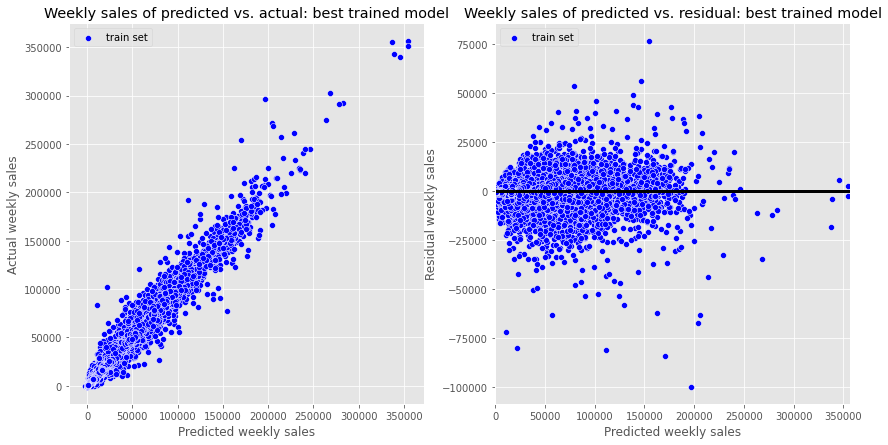

In [23]:
# Plot a comparison scatter plot: predicted vs. actual
plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plot_reg_compare(df_val['Weekly_Sales_Pred'], df_val['Weekly_Sales'])
plt.title('Weekly sales of predicted vs. actual: best trained model')

# Plot a residual scatter plot: predicted vs. actual
plt.subplot(1,2,2)
plot_reg_residual(df_val['Weekly_Sales_Pred'], df_val['Weekly_Sales'])
plt.title('Weekly sales of predicted vs. residual: best trained model')
plt.show()

### Model Evaluation: Comparison and Residual Plots ###
1st figure showed the straight line which indicated how closely predicted and actual weekly sales were plotted.

2nd figure showed the residual weekly sales across the different predicted weekly sales. 

Thus, higher the predicted weekly sales, greater the residual weekly sales (middle range:). 

## Part 4 - DEPLOY ##

In [24]:
# --- 19. Automate the model pipeline --- #
# make predictions on a test set
df_pred_test = model.predict(df_final_test[list_feat])
df_pred_test = pd.DataFrame(df_pred_test)
df_pred_test.columns = ['Sales_Var_Med_Weekly_Pred']

# make predictions dataframe:
results = pd.concat([df_final_test.reset_index(drop=True), df_pred_test], axis=1)
results['Weekly_Sales_Pred'] = results['Median_Sales']-results['Sales_Var_Med_Weekly_Pred']
results = results[['Store', 'Dept', 'Date_String', 'Weekly_Sales_Pred']]

# create a final predicted dataframe:
results = gen_predictions_file(results, 'Store', 'Dept', 'Date_String')
results.head()

,id,Weekly_Sales_Pred
0,1_1_2012-11-02,26205.270762
1,1_1_2012-11-09,19392.325114
2,1_1_2012-11-16,19460.812731
3,1_1_2012-11-23,19809.206646
4,1_1_2012-11-30,19795.602579


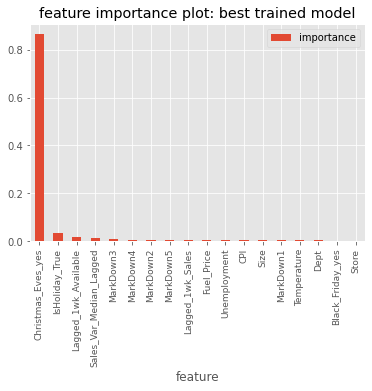

In [25]:
# --- 20. Deploy the solution --- #
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
#linear models don't have feature_importances
    importances = [0]*len(df_final_train[list_feat].columns)
    
feature_importances = pd.DataFrame({'feature':df_final_train[list_feat].columns, 
                                        'importance':importances})
feature_importances.sort_values(by='importance', ascending=False,
                                    inplace=True)
    
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)
    
#create a plot
feature_importances[0:20].plot.bar(align='center')
plt.xticks(rotation=90, fontsize=9)
plt.title('feature importance plot: best trained model')
plt.show()
    
#Save model results as .csv file:
model_results(model, mean_mae[model], results, feature_importances)

### Model Summary: Feature Importance ###
A figure showed the feature importance of the best trained model from an order of the highest to lowest ranks.

Top 5 important features were Sales Variance Median-to-Lagged followed by Lagged 1week Sales, and Christmas Eves.